# Cooperative optimization for data science

## Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import cvxpy as cp
import math


In [2]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)

Text(0.5, 1.0, 'Data visualization')

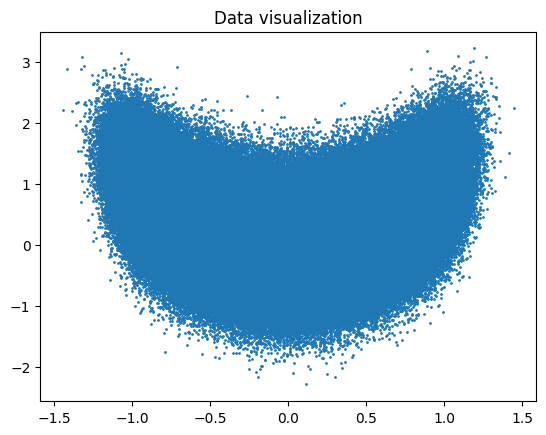

In [3]:
plt.scatter(x, y, s=1)
plt.title("Data visualization")

## Define the parameters

In [4]:
n = 100 # x_selected
m = 10
a = 5
sigma = 0.5
nu = 1

In [5]:
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = [x[i] for i in ind]
y_selected = [y[i] for i in ind]

Text(0, 0.5, 'y')

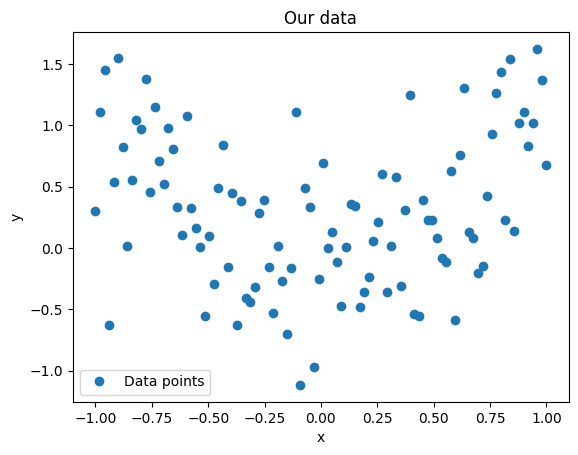

In [6]:
# Plot the selected points

plt.plot(x[:n],y[:n],'o', label = "Data points")
#plt.plot(x_selected,y_selected,'o',label="Selected points")
plt.title("Our data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

<h2> Utils

In [7]:
def kernel(x, y):
    K = np.exp(-np.linalg.norm(x - y)**2)
    return K

In [8]:
def matrix_K(x, y):
    p = len(x)
    q = len(y)
    K = np.zeros((p,q))
    for i in range(p):
        for j in range(q):
            K[i][j] = kernel(x[i],y[j])
    return K

In [9]:
def plot_f(nt, alpha_method, title, method):
    x_prime = np.linspace(-1, 1, nt)
    f_values_alpha = np.zeros_like(x_prime)

    # Compute the function values for each point in the grid
    for i, xi in enumerate(x_prime):
        # Evaluate the function at the current grid point
        f_values_alpha[i] = sum([alpha_method[j] * kernel(xi, x_selected[j]) for j in range(10)])

    # Plot the obtained function
    plt.plot(x[:n],y[:n], 'o', label = 'Data')
    #plt.plot(x_selected, y_selected, 'o', label = 'Selected points')
    plt.plot(x_prime, f_values_alpha_star, label='f reconstructed alpha star')
    plt.plot(x_prime, f_values_alpha, linestyle='--', label=f'f reconstructed using {method}')
    plt.xlabel('x')
    plt.ylabel('Function Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

We define the communication graph below :

In [10]:
# cycle
# w = [[1/3, 1/3, 0, 0, 1/3], [1/3, 1/3, 1/3, 0, 0], [0, 1/3, 1/3, 1/3, 0], [0, 0, 1/3, 1/3, 1/3], [1/3, 0, 0, 1/3, 1/3]]

# fully connected
w = [[1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5], [1/5, 1/5, 1/5, 1/5, 1/5]]

# line graph
# w = [[1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 0, 1, 1]]

# small-world graph
# w = [[0, 1/2, 0, 0, 1/2], [1, 0, 1, 1, 0], [0, 1, 0, 1, 0], [0, 1, 1, 0, 1], [1, 0, 0, 1, 0]]

# test
# w = [[1/4, 0, 1/4, 1/4, 1/4], [1/4, 1, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4], [1/4, 0, 1/4, 1/4, 1/4]]

<h2> Compute optimal $\alpha*$ using linear algebra

In [11]:
# Construct the problem.
Knn = matrix_K(x[:n], x[:n])
Kmm = matrix_K(x_selected,x_selected)
Knm = matrix_K(x[:n],x_selected)

In [12]:
np.linalg.det(Kmm + Knm.T@Knm/(sigma**2))

-2.833760565875236e-48

In [13]:
alpha_star = np.linalg.solve((sigma**2)*Kmm + Knm.T@Knm + nu*np.eye(m),Knm.T@y[:n])

In [14]:
alpha_star

array([ 1.37698864,  0.09456658,  0.12405982, -0.24426302,  0.56427314,
       -0.64427153,  0.68385419, -0.72828696,  0.02518999, -0.59951995])

Reconstruct f using $\alpha^{*}$

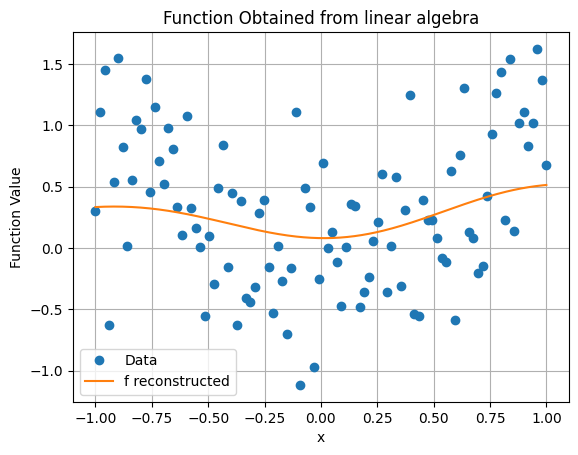

In [15]:
nt = 250
x_prime = np.linspace(-1, 1, nt)
alpha = alpha_star

f_values_alpha_star = np.zeros_like(x_prime)

# Compute the function values for each point in the grid
for i, xi in enumerate(x_prime):
    # Evaluate the function at the current grid point
    f_values_alpha_star[i] = sum([alpha[j] * kernel(xi, x_selected[j]) for j in range(m)])

# Plot the obtained function
plt.plot(x[:n],y[:n], 'o', label = 'Data')
#plt.plot(x_selected, y_selected, 'o', label = 'Selected points')
plt.plot(x_prime, f_values_alpha_star, label='f reconstructed')
plt.xlabel('x')
plt.ylabel('Function Value')
plt.title('Function Obtained from linear algebra')
plt.legend()
plt.grid(True)
plt.show()

<h2> Decentralized gradient descent with Laplacian Noise (DGD-DP)

In this part we will need the value of $\alpha^{*}$ found above to compute the optimality gap at each iteration

For each agent $a \in \{1,...5\}$ we define the following function:

\begin{equation*} g_{a}(\alpha) = \frac{\sigma^2}{5}\frac{1}{2}\alpha^{T}K_{mm}\alpha + \frac{1}{2}\vert\vert y - K_{(i)m}\alpha\vert\vert + \frac{\nu}{10}\vert\vert \alpha \vert \vert^{2}_{2} \end{equation*}

In [16]:
K = matrix_K(x[:n], x[:n])
Kmm = K[ind,:][:,ind]
agents = np.array_split(np.random.choice(np.array(range(n)),size=n, replace=False),a)

In [17]:
def compute_local_gradient(alpha, a, sigma, y, K, M, agents):
    
    Kmm = K[M,:][:,M]
    
    somme = np.zeros(len(alpha))
    for i in agents[a]:
        Kim = K[i,:][M]
        somme += (y[i] - Kim@alpha)*Kim.T
        
    return (sigma**2)*Kmm@alpha/5  - somme + (nu/len(agents))*alpha

In [18]:
def DGD_DP(num_iterations, agents, ind, K, y, sigma, alpha_star, W, epsilons):

    nb_agents = a
    
    m = len(ind)
    
    opt_gap = np.zeros((len(epsilons),num_iterations)) # optimality gap
    
    alpha = np.zeros((len(epsilons), nb_agents, m))
    
    for e in range(len(epsilons)):
        for k in range(num_iterations):
            new_alpha = alpha[e].copy()

            gamma_k = gamma(k)
            step_size_k = step_size(k)
            nu_k = variance(k, epsilons[e])
            zeta_k = np.random.laplace(scale=np.sqrt(nu_k/2), size=m)


            for i in range(nb_agents):
                grad = compute_local_gradient(alpha[e, i], i, sigma, y, K, ind, agents)
                
                for j in range(nb_agents):
                    if j != i:
                        new_alpha[i] += gamma_k * W[i][j] * (alpha[e,j] + zeta_k - alpha[e,i])

                new_alpha[i] -= step_size_k * grad
        
            alpha[e] = new_alpha.copy()
            opt_gap[e, k] = np.linalg.norm(alpha[e] - alpha_star)
        
    return alpha, opt_gap

In [19]:
M = ind
W = w
true_alpha_linalg = alpha_star
num_iterations = 10000
K = matrix_K(x[:n],x[:n])

def step_size(k):
    return 0.002/(1+0.001*k)

def gamma(k):
    return 1/(1+0.001*(k**0.9))

# variance of the Laplacian distribution (nu)
def variance(k, epsilon):
    return 0.01/epsilon * 1/(1+0.001*(k**0.1))

epsilons = [0.1, 1, 10]

alpha_dgd_dp, opt_gap_dgd_dp = DGD_DP(num_iterations,agents,M, K,y[:n],sigma,true_alpha_linalg, W, epsilons)

In [20]:
alpha_dgd_dp = np.mean(alpha_dgd_dp,axis=1)

## Visualize the functions obtained

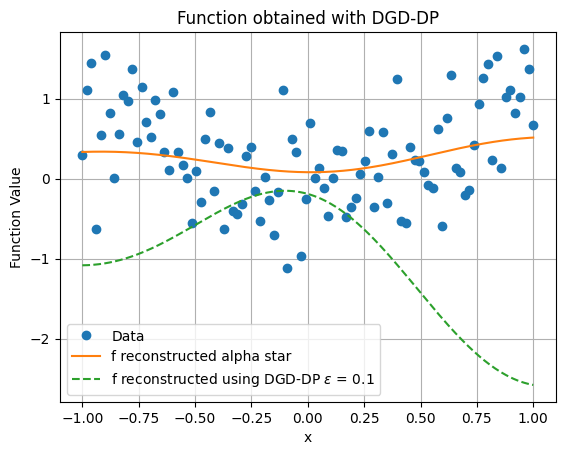

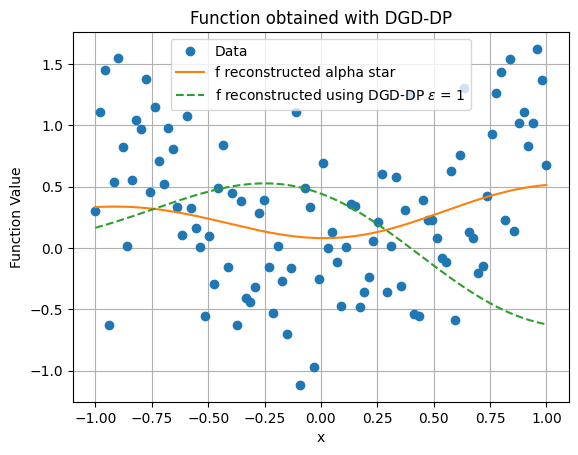

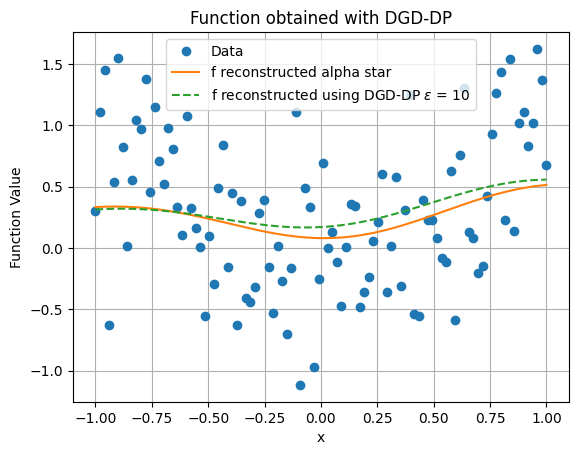

In [21]:
nt = 250
title = 'Function obtained with DGD-DP'
for e in range(len(epsilons)):
    method = f'DGD-DP $\\epsilon$ = {epsilons[e]}'
    plot_f(nt, alpha_dgd_dp[e], title, method)
x_prime = np.linspace(-1, 1, nt)

plt.show()

<h2> Plot optimality gap

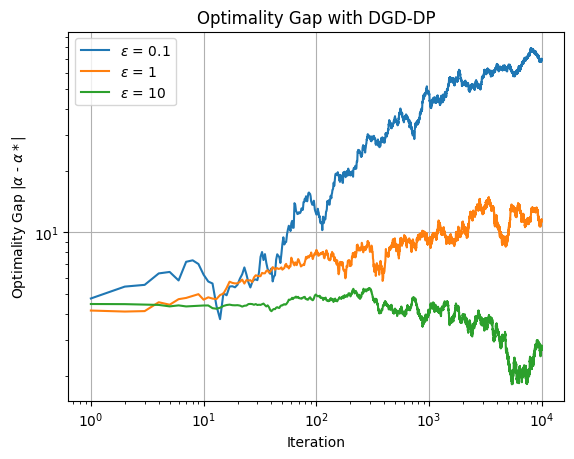

In [24]:
plt.figure()

for e in range(len(epsilons)):
    plt.loglog(np.arange(1, num_iterations + 1), opt_gap_dgd_dp[e], label=f'$\\epsilon$ = {epsilons[e]}')

plt.xlabel("Iteration")
plt.ylabel("Optimality Gap |$\\alpha$ - $\\alpha*$|")
plt.title("Optimality Gap with DGD-DP")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()